# <div align='center'> Test Flowers </div>

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import Image as IMG
from PIL import Image
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models
from torchvision import datasets
from torch import optim
from torch.utils.data import (Dataset, DataLoader)
from k12libs.utils.nb_easy import K12AI_PRETRAINED_ROOT, K12AI_DATASETS_ROOT, k12ai_get_top_dir

In [2]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [3]:
dataset = 'rflowers'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)

In [4]:
!cat $data_root/info.json

{
    "num_records": 1760,
    "num_classes": 22,
    "label_names": [
        "salviasplendens",
        "daffodil",
        "snowdrop",
        "lilyvalley",
        "bluebell",
        "crocus",
        "iris",
        "tigerlily",
        "tulip",
        "fritillary",
        "sunflower",
        "daisy",
        "coltsfoot",
        "dandelion",
        "cowslip",
        "buttercup",
        "windflower",
        "pansy",
        "coxcomb",
        "flamingo",
        "lily",
        "lotus"
    ],
    "mean": [
        0.4623,
        0.4305,
        0.295
    ],
    "std": [
        0.252,
        0.2242,
        0.2091
    ]
}

In [5]:
!tree -d /data/datasets/cv/rflowers

/data/datasets/cv/rflowers
├── imgs
│   ├── 0
│   ├── 1
│   ├── 10
│   ├── 11
│   ├── 12
│   ├── 13
│   ├── 14
│   ├── 15
│   ├── 16
│   ├── 17
│   ├── 18
│   ├── 19
│   ├── 2
│   ├── 20
│   ├── 21
│   ├── 3
│   ├── 4
│   ├── 5
│   ├── 6
│   ├── 7
│   ├── 8
│   └── 9
├── raw
│   ├── 0
│   ├── 1
│   ├── 10
│   ├── 11
│   ├── 12
│   ├── 13
│   ├── 14
│   ├── 15
│   ├── 16
│   ├── 17
│   ├── 18
│   ├── 19
│   ├── 2
│   ├── 20
│   ├── 21
│   ├── 3
│   ├── 4
│   ├── 5
│   ├── 6
│   ├── 7
│   ├── 8
│   └── 9
└── samples

47 directories


In [6]:
### 
with open(os.path.join(data_root, 'info.json'), 'r') as fr:
    items = json.load(fr)

### 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),    # 数据增强: 对PIL Image数据做随机水平翻转
    transforms.ToTensor(),                     # PIL Image格式转换为Tensor张量格式               
    transforms.Normalize(items['mean'], items['std']) # 对数据归一化处理
])

In [27]:
items

{'num_records': 1760,
 'num_classes': 22,
 'label_names': ['salviasplendens',
  'daffodil',
  'snowdrop',
  'lilyvalley',
  'bluebell',
  'crocus',
  'iris',
  'tigerlily',
  'tulip',
  'fritillary',
  'sunflower',
  'daisy',
  'coltsfoot',
  'dandelion',
  'cowslip',
  'buttercup',
  'windflower',
  'pansy',
  'coxcomb',
  'flamingo',
  'lily',
  'lotus'],
 'mean': [0.4623, 0.4305, 0.295],
 'std': [0.252, 0.2242, 0.2091]}

In [7]:
class JsonfileDataset(Dataset):
    def __init__(self, data_root, json_file, resize=None, transform=None):
        self.data_root = data_root
        self.json_file = json_file
        self.resize = resize
        self.image_list, self.label_list = self.__read_jsonfile(json_file)
        if transform:
            self.transform = transform
        else:
            self.transform = transforms.Compose([transforms.ToTensor()])

    def __getitem__(self, index):
        img = Image.open(self.image_list[index]).convert('RGB')
        if self.resize:
            img = img.resize(self.resize)
        if self.transform is not None:
            img = self.transform(img)
        return img, self.label_list[index]

    def __len__(self):
        return len(self.image_list)

    def __read_jsonfile(self, jsonfile):
        image_list = []
        label_list = []
        with open(os.path.join(self.data_root, self.json_file)) as f:
            items = json.load(f)
            for item in items:
                image_list.append(os.path.join(self.data_root, item['image_path']))
                label_list.append(item['label'])
        return image_list, label_list

In [12]:
train_data = JsonfileDataset(data_root, 'all.json', transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=True) 

valid_data = JsonfileDataset(data_root, 'val.json', transform=transform)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=True, drop_last=False) 

In [9]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 22)

# model = models.vgg16_bn(pretrained=True)
# model.classifier[6] = nn.Linear(4096, 22)

model = model.to('cuda')

## 超参数调整

In [17]:
### 设置训练轮回(max_epoch)
max_epoch = 20

### 设置损失函数(交叉熵CE)
reduction = 'mean' # 约简方式为mean(张量各个维度上的元素的平均值)
criterion = nn.CrossEntropyLoss(reduction=reduction)

### 设置优化器(随机梯度下降SGD)
# optimizer = SGD(model.parameters(),
#    lr=0.01,           # 基础学习率
#    weight_decay=1e-6, # 权重衰减, 使得模型参数值更小, 有效防止过拟合
#    momentum=0.9,      # 动量因子, 更快局部收敛
#    nesterov=True      # 使用Nesterov动量, 加快收敛速度
# )  

### 亚当
optimizer = Adam(
    filter(lambda p: p.requires_grad, model.parameters()), # 过程出可更新的层(参数)
    lr=0.001,           # 基础学习率
    betas=(0.9, 0.999), # 计算梯度的均值(0.9)和平方(0.999)的系数
    eps=1e-8,           # 为了防止分母除零, 分母加上非常小的值
    weight_decay=0,     # 权重衰减
    amsgrad=True,      # 是否使用AmsGrad变体
)

### 设置学习率衰减策略(可选, 固定步长衰减StepLR)
# scheduler = StepLR(optimizer,
#    step_size=2, # 每间隔2次epoch进行一次LR调整
#    gamma=0.6    # LR调整为原来0.6倍
# )                 
 
scheduler = ReduceLROnPlateau(
    optimizer,   # 优化器
    mode='min',  # 指定指标不再下降
    factor=0.1,  # 衰减因子
    patience=2,  # 容忍多少次(指标不改变)
    min_lr=1e-8, # 最小的lr
    eps=1e-6,    # 学习率衰减到的最小值eps时,学习率不再改变
)


## 模型训练及反馈

In [18]:
def train_epoch(model, device, data_loader, criterion, optimizer, epoch):
    ### 模型进入训练状态(启用 BN 和 Dropout)
    model.train()
    for i, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1]
        batch_acc = 100.0 * (pred == target).sum().item() / len(target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        if i % 30 == 0:
            print('Epoch:', epoch, 'Training Loss:', loss.item(), 'Training Batch Acc:', batch_acc)
    print('Epoch:', epoch, 'Training Loss:', loss.item())
        
def valid_epoch(model, device, data_loader, criterion, epoch):
    ### 模型进入评估模式(禁用 BN 和 Dropou)
    model.eval()
    correct = 0
    with torch.no_grad():
        losses = []
        for i, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            pred = torch.max(output, 1)[1]
            correct += (pred == target).sum().item()
            if i % 30 == 0:
                print('Epoch:', epoch, 'Validing Loss:', loss.item())
            losses.append(loss)
        avg_loss = torch.stack(losses).mean()
    ### 计算正确率
    acc = 100.0 * correct / len(data_loader.dataset)
    ### 调整学习率
    scheduler.step(avg_loss)
    print('Epoch:', epoch, 'LR:', scheduler._last_lr, 'Validing Avg Loss:', avg_loss.item(), 'ACC:', acc)
    return acc
    
def train(epoch_num, model, train_loader, valid_loader, criterion, optimizer, scheduler):
    ### 获取模型训练所用设备(cpu或者gpu)
    device = next(model.parameters()).device
    for epoch in range(0, epoch_num):
        ### 训练模型
        train_epoch(model, device, train_loader, criterion, optimizer, epoch)
        ### 校验模型
        valid_epoch(model, device, valid_loader, criterion, epoch)

    ### 保存模型
    torch.save(model.state_dict(), "last.pt")
        
### 启动训练
train(max_epoch, model, train_loader, valid_loader, criterion, optimizer, scheduler)

Epoch: 0 Training Loss: 0.0003616908215917647 Training Batch Acc: 100.0
Epoch: 0 Training Loss: 0.08716854453086853
Epoch: 0 Validing Loss: 0.4994312524795532
Epoch: 0 LR: [0.001] Validing Avg Loss: 0.6471790671348572 ACC: 85.87896253602305
Epoch: 1 Training Loss: 0.04361916705965996 Training Batch Acc: 97.65625
Epoch: 1 Training Loss: 0.06559291481971741
Epoch: 1 Validing Loss: 0.14063380658626556
Epoch: 1 LR: [0.001] Validing Avg Loss: 0.19543877243995667 ACC: 94.52449567723343
Epoch: 2 Training Loss: 0.05883210524916649 Training Batch Acc: 98.4375
Epoch: 2 Training Loss: 0.03601653128862381
Epoch: 2 Validing Loss: 0.5920577645301819
Epoch: 2 LR: [0.001] Validing Avg Loss: 0.5555209517478943 ACC: 90.20172910662824
Epoch: 3 Training Loss: 0.10194837301969528 Training Batch Acc: 96.875
Epoch: 3 Training Loss: 0.024542562663555145
Epoch: 3 Validing Loss: 0.14592397212982178
Epoch: 3 LR: [0.001] Validing Avg Loss: 0.3061898648738861 ACC: 93.0835734870317
Epoch: 4 Training Loss: 0.0183552

## 模型评估及测试

In [22]:
### 加载测试数据集
test_data = JsonfileDataset(data_root, 'test.json', transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=False) 

### 加载训练完成的模型
test_model = models.resnet18(pretrained=False)
test_model.fc = nn.Linear(test_model.fc.in_features, 22)
test_model.load_state_dict(torch.load('last.pt'))

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            pred = torch.max(output, 1)[1]
            correct += (pred == target).sum().item()
    ### 计算正确率
    acc = 100.0 * correct / len(data_loader.dataset)
    return acc

### 启动评估
acc = evaluate(test_model, test_loader)
print("Acc:", acc)

Acc: 100.0


In [24]:
def predict(model, img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        ])

    inputs = transform(img).unsqueeze(0)

    with torch.no_grad():
        outputs = model(inputs)
        result = outputs.argmax(dim=1).item()

    return result                                           

test_pic1 = os.path.join(k12ai_get_top_dir(), 'assets/images', 'flower_0.jpg')
test_pic2 = os.path.join(k12ai_get_top_dir(), 'assets/images', 'flower_1.jpg')
test_pic3 = os.path.join(k12ai_get_top_dir(), 'assets/images', 'flower_2.jpg')
items['label_names'][predict(test_model, test_pic1)], \
items['label_names'][predict(test_model, test_pic2)], \
items['label_names'][predict(test_model, test_pic3)]

('tulip', 'fritillary', 'salviasplendens')

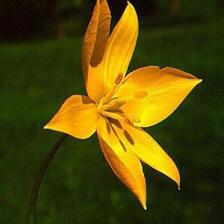

In [25]:
IMG(test_pic1)

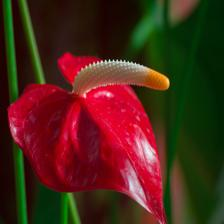

In [26]:
IMG(test_pic2)

------------------